# 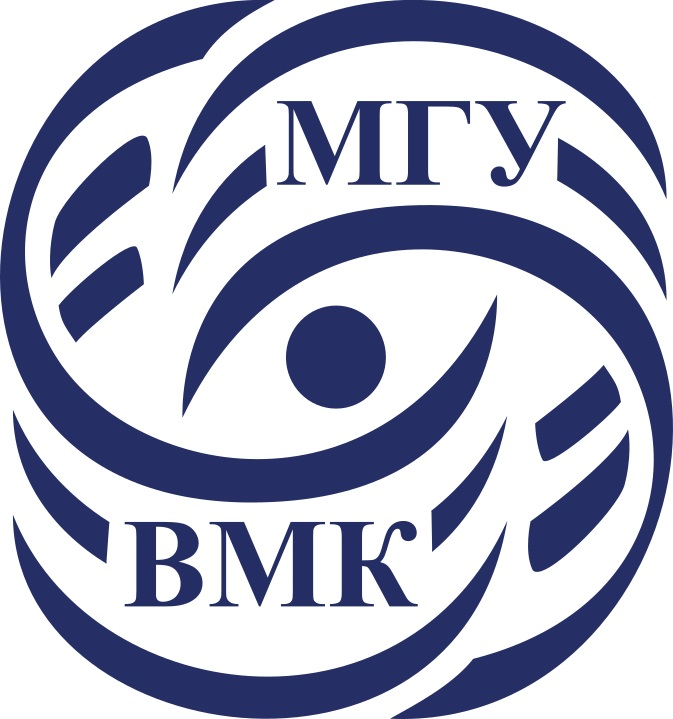

# Машинное обучение. ВМК МГУ

# Практическое задание 5: SVM
## Уровень: <font color='MediumSeaGreen'>**Исследовательский (Research)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите нюансы работы модели SVM
* Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
* Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [1]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.08MB/s]


Проверим версию библиотеки:

In [2]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [4]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [5]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [6]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [7]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder contents


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: /content/05-SVM/imbalanced/X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 4.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: /content/05-SVM/imbalanced/X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 5.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: /content/05-SVM/imbalanced/y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: /content/05-SVM/imbalanced/y_imb.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5
To: /content/05-SVM/public/cX_test.npy
100%|██████████| 8.13k/8

['/content/05-SVM/imbalanced/X_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/X_imb.npz.npy',
 '/content/05-SVM/imbalanced/y_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/y_imb.npz.npy',
 '/content/05-SVM/public/cX_test.npy',
 '/content/05-SVM/public/cX_train.npy',
 '/content/05-SVM/public/cy_train.npy']

Перед выполнение данного ноутбука рекомендуем просмотреть базовый ноутбук по SVM

# Форма разделяющей поверхности для несбалансированных классов

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Иногда, выбранная форма поверхности может плохо подходить для целевого распределения объектов. Особенно это может быть заметно, если соотношение  классов в обучении отличается от тестового. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.

Давайте обучим SVC на несбалансированных данных и построим разделяющую поверхность для тестовой выборки с другим соотношением классов.

In [8]:
X_distr1 = np.load('05-SVM/imbalanced/X_imb.npz.npy')
y_distr1 = np.load('05-SVM/imbalanced/y_imb.npz.npy')
X_distr2 = np.load('05-SVM/imbalanced/X_imb_test.npz.npy')
y_distr2 = np.load('05-SVM/imbalanced/y_imb_test.npz.npy')

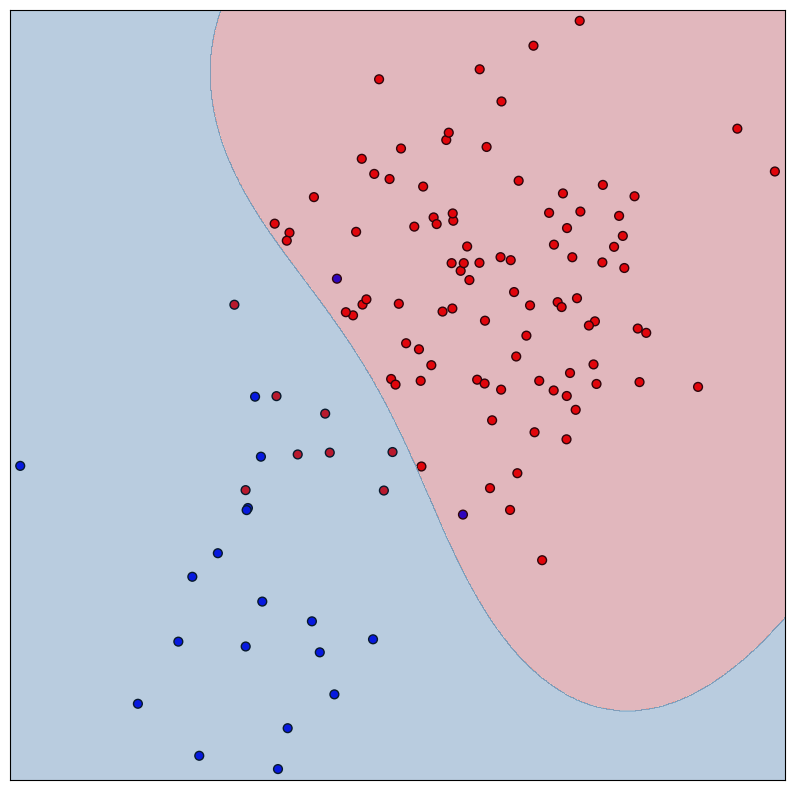

In [9]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model)

-----------
<font color="white" style="opacity:0.2023"></font>

Так как синих объектов было существенно больше в обучении, разделяющая поверхность отнесла к этому классу большую часть пространства около границы классов. При этом, из-за возросшего количества красных объектов в тестовой выборке, многие из них стали ошибочно относиться к другому классу.

Один из способов исправить эту проблему - это повлиять на форму поверхности с помощью задания весов классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального.
    


## <font color='DarkOrange'>**Задание 1 [2 баллa]**</font>

В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  **Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}. В качестве метрики, которую нужно оптимизировать нужно использовать accuracy на (X_distr2, y_dist2).**

In [10]:
from itertools import product

In [13]:
w1_best, w2_best = None, None
best_acc = None
grid = [0.01, 0.1, 0.5, 1.0, 5, 10, 100, 1000]
for w1, w2 in product(grid, grid):
    svc_cls = SVC(C=1.0, class_weight={1: w1, 0: w2})
    svc_cls.fit(X_distr1, y_distr1)
    acc = accuracy_score(y_distr2, svc_cls.predict(X_distr2))
    # Save model with best accuracy
    # Your code here
    if (best_acc is None) or (acc > best_acc):
      best_acc, w1_best, w2_best = acc, w1, w2



print(f'Weight1: {w1_best},\nWeight2: {w2_best},\nBest accuracy: {best_acc}')

Weight1: 0.1,
Weight2: 5,
Best accuracy: 0.9666666666666667


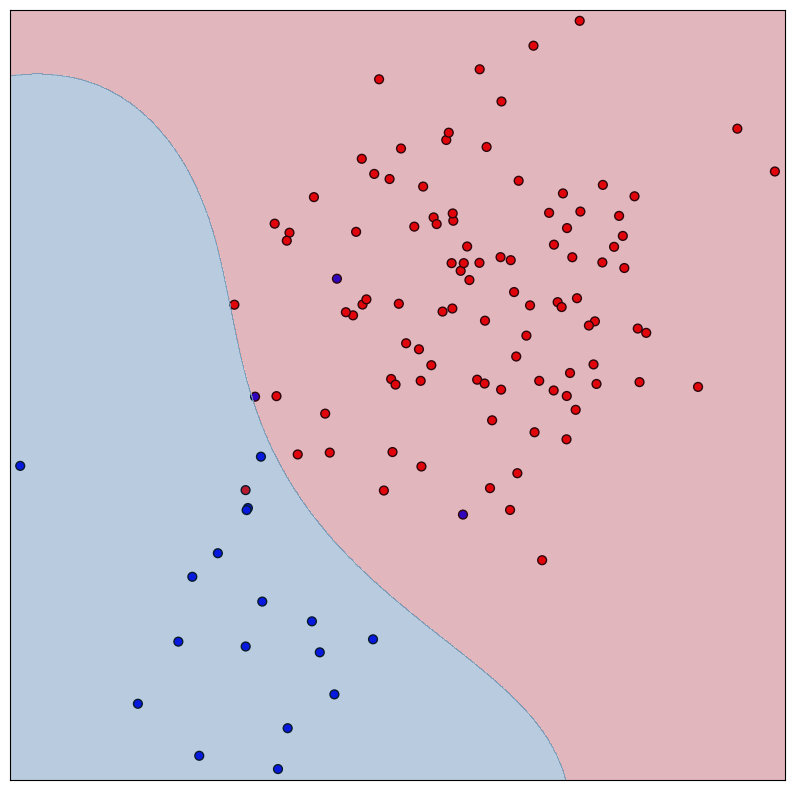

In [14]:
# best_svc_cls = ...
# Your code here

best_svc_cls = SVC(C=1.0, class_weight={1: w1_best, 0: w2_best})
best_svc_cls.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, best_svc_cls)

In [15]:
print('My best classifier:')
print('Accuracy:', accuracy_score(y_distr2, best_svc_cls.predict(X_distr2)))

My best classifier:
Accuracy: 0.9666666666666667


# Ограничения SVM

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков.    Нужно провести два эксперимента.

## <font color='DarkOrange'>**Задание 2 [2 баллa]**</font>
    
В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n).
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте
    с помощью стандартной библиотеки time (пример в ячейке ниже).
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

<font color='OrangeRed'>**Внимание!**</font> во время замеров времени работы, отключите сторонние процессы, занимающие CPU, иначе замеры времени работы окажутся некорректными. Помните, что времени работы в зависимости от числа данных и признаков должно меняться монотонно, без ступенчатых изменений (за исключением небольшого шума).

In [16]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.0014166831970215


In [17]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

In [19]:
from sklearn.linear_model import LogisticRegression
t_svc = []
t_logreg = []
for n in range(1000, 10001, 1000):
  X, y = generate_data_with_balanced_classes(size=n)
  model = SVC()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_svc.append(end - st)
  model = LogisticRegression()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_logreg.append(end - st)
  print(f"n:{n}, SVC_t:{t_svc[-1]}, LogReg_t:{t_logreg[-1]}")

n:1000, SVC_t:0.031234264373779297, LogReg_t:0.016759395599365234
n:2000, SVC_t:0.09450435638427734, LogReg_t:0.007909536361694336
n:3000, SVC_t:0.18486976623535156, LogReg_t:0.02910900115966797
n:4000, SVC_t:0.3782484531402588, LogReg_t:0.03357124328613281
n:5000, SVC_t:0.4441978931427002, LogReg_t:0.03022289276123047
n:6000, SVC_t:0.6374356746673584, LogReg_t:0.02334904670715332
n:7000, SVC_t:0.6722698211669922, LogReg_t:0.03568863868713379
n:8000, SVC_t:1.1570460796356201, LogReg_t:0.016200780868530273
n:9000, SVC_t:0.6132872104644775, LogReg_t:0.01790332794189453
n:10000, SVC_t:0.797083854675293, LogReg_t:0.022058963775634766


## <font color='DarkOrange'>**Задание 3 [2 баллa]**</font>

Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков.
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке `range(10, 1001, 100)`.

Постройте графики времени работы в зависимости от числа признаков для SVM и логистической регрессии, сравните их и сделайте выводы.
    
<font color='LightSteelBlue'>**Подсказка**</font> Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции.

In [20]:
# Your code here
from sklearn.linear_model import LogisticRegression
t_svc = []
t_logreg = []
for n in range(10, 1001, 100):
  X, y = generate_data_with_balanced_classes(size=n)
  model = SVC()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_svc.append(end - st)
  model = LogisticRegression()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_logreg.append(end - st)
  print(f"n:{n}, SVC_t:{t_svc[-1]}, LogReg_t:{t_logreg[-1]}")

n:10, SVC_t:0.0020475387573242188, LogReg_t:0.004790544509887695
n:110, SVC_t:0.0018625259399414062, LogReg_t:0.002595186233520508
n:210, SVC_t:0.0025310516357421875, LogReg_t:0.0031363964080810547
n:310, SVC_t:0.003664731979370117, LogReg_t:0.0031576156616210938
n:410, SVC_t:0.0045549869537353516, LogReg_t:0.003345012664794922
n:510, SVC_t:0.0056400299072265625, LogReg_t:0.00417017936706543
n:610, SVC_t:0.008834362030029297, LogReg_t:0.0034804344177246094
n:710, SVC_t:0.009980201721191406, LogReg_t:0.004000425338745117
n:810, SVC_t:0.010505437850952148, LogReg_t:0.004057407379150391
n:910, SVC_t:0.013729572296142578, LogReg_t:0.004317522048950195


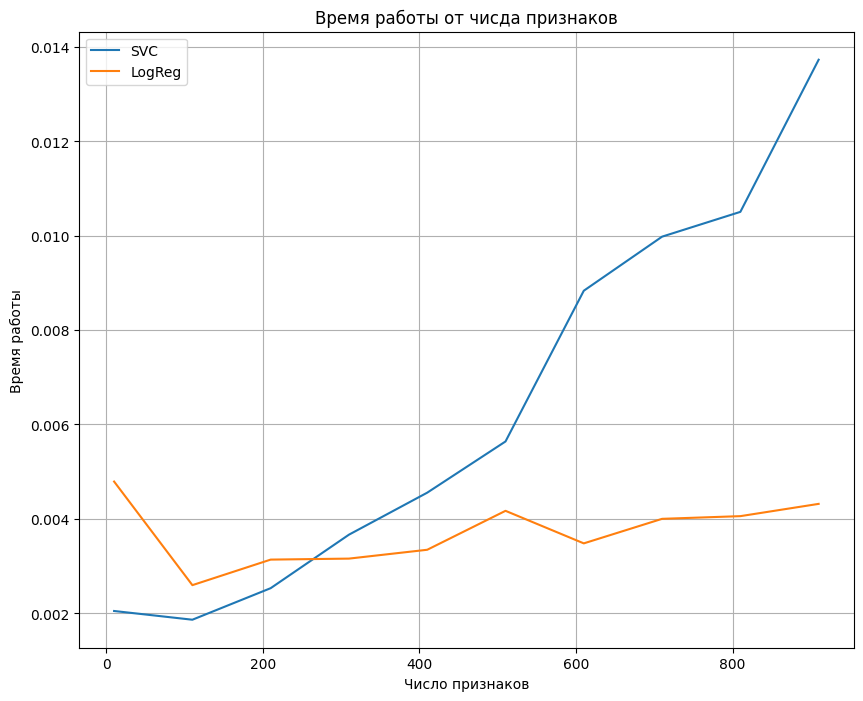

In [24]:
plt.figure(figsize=(10, 8))
plt.title("Время работы от чисда признаков для 2го эксперимента")
plt.grid()
plt.xlabel("Число признаков")
plt.ylabel("Время работы")
plt.plot(range(10, 1001, 100), t_svc, label="SVC")
plt.plot(range(10, 1001, 100), t_logreg, label="LogReg")
plt.legend()
plt.show()

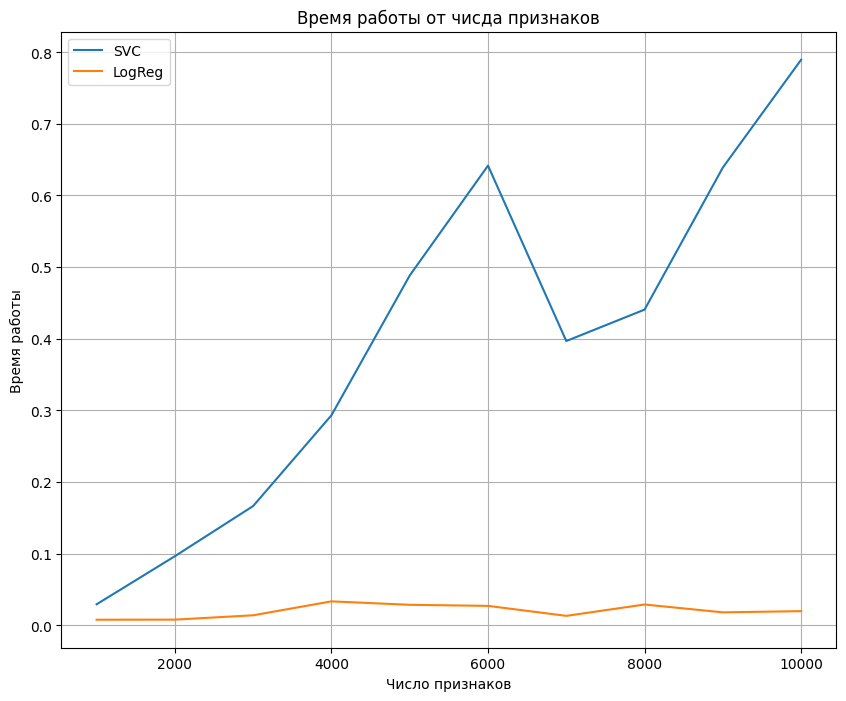

In [25]:
from sklearn.linear_model import LogisticRegression
t_svc = []
t_logreg = []
for n in range(1000, 10001, 1000):
  X, y = generate_data_with_balanced_classes(size=n)
  model = SVC()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_svc.append(end - st)
  model = LogisticRegression()
  st = time.time()
  model.fit(X, y)
  end = time.time()
  t_logreg.append(end - st)
plt.figure(figsize=(10, 8))
plt.title("Время работы от чисда признаков для первого эксперимента")
plt.grid()
plt.xlabel("Число признаков")
plt.ylabel("Время работы")
plt.plot(range(1000, 10001, 1000), t_svc, label="SVC")
plt.plot(range(1000, 10001, 1000), t_logreg, label="LogReg")
plt.legend()
plt.show()

<font color='MediumOrchid'>**Ваши выводы тут:**</font>
Для SVM основное время уходит на решение задачи оптимизации, которая зависит от числа объектов, поскольку каждый объект может быть опорным.
Для логистической регрессии градиентные методы быстрее, и вычисления зависят только от количества параметров (признаков) и числа итераций.

Таким образом, для больших объемов данных логистическая регрессия предпочтительнее по времени, особенно если задача линейно разделима. SVM может быть более точным в сложных случаях, но для больших данных может потребоваться уменьшение числа объектов через отбор признаков или использование приближений.


# Уменьшение размерности входа

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит такое линейное пространство меньшей размерности $k$ ($k << d$, где d изначальная размерность входа), проекция на которое теряет меньше всего информации. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca.

## <font color='DarkOrange'>**Задание 4 [2 баллa]**</font>


    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA.
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - "луны", а остальные координаты, случайные.
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность).
    
<font color='OrangeRed'>**Обратите внимание!**</font> Не забывайте делить выборку на обучение и валидацию в этом эксперименте (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже.

In [26]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [27]:
X_moons.shape

(2000, 1000)

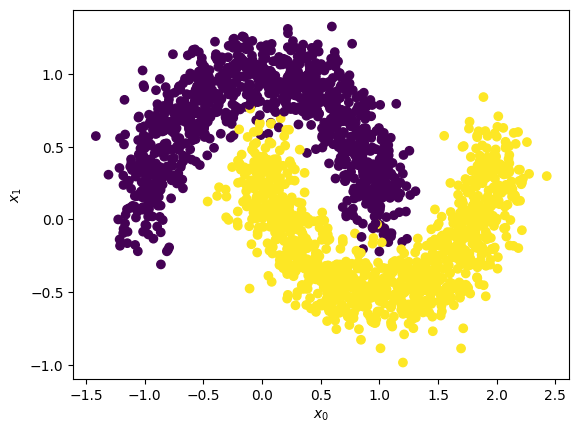

In [28]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

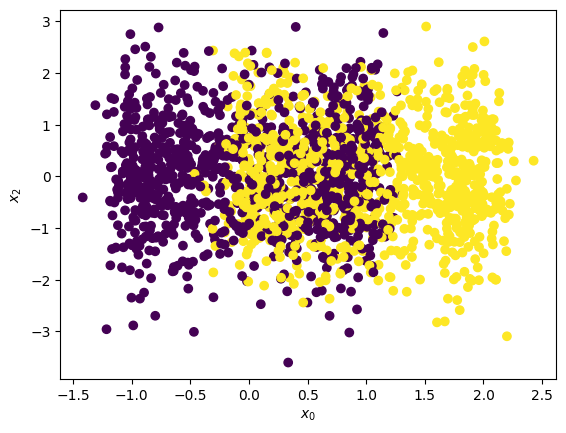

In [30]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

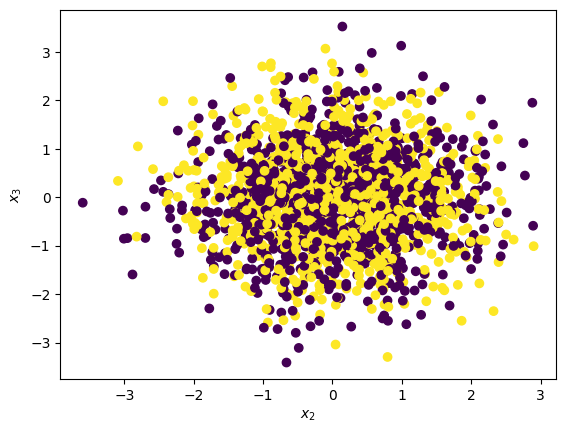

In [29]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [ ]:
# Пример правильного обучения PCA с делением на train/test
pca_model = PCA(n_components=500)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
    X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

print(X_moons.shape, y_moons.shape)
print(X_moons_train.shape, y_moons_train.shape)
print(X_train_for_pca.shape, y_train_for_pca.shape)

# Учим PCA
pca_model.fit(X_train_for_pca)

# Применяем PCA
X_moons_test_transformed = pca_model.transform(X_moons_test)
X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

print(X_train_for_svc_transformed.shape)

# Учим SVC (на другой выборке чтобы не переобучиться)
svc_on_transformed = SVC(kernel='rbf')
svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)

preds = svc_on_transformed.predict(X_moons_test_transformed)

print('Accuracy after PCA:', accuracy_score(preds, y_moons_test))

In [32]:
# Your code here
t, acc = [], []
for i in range(10, 500, 5):
  # Пример правильного обучения PCA с делением на train/test
  pca_model = PCA(n_components=i)

  X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
      X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

  X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
      X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма
  st = time.time()
  # Учим PCA
  pca_model.fit(X_train_for_pca)
  end = time.time()
  pca_t = end - st
  # Применяем PCA
  X_moons_test_transformed = pca_model.transform(X_moons_test)
  X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)
  # Учим SVC (на другой выборке чтобы не переобучиться)
  svc_on_transformed = SVC(kernel='rbf')
  st = time.time()
  svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)
  end = time.time()
  svc_t = end - st
  preds = svc_on_transformed.predict(X_moons_test_transformed)
  t.append(pca_t + svc_t)
  acc.append(accuracy_score(preds, y_moons_test))

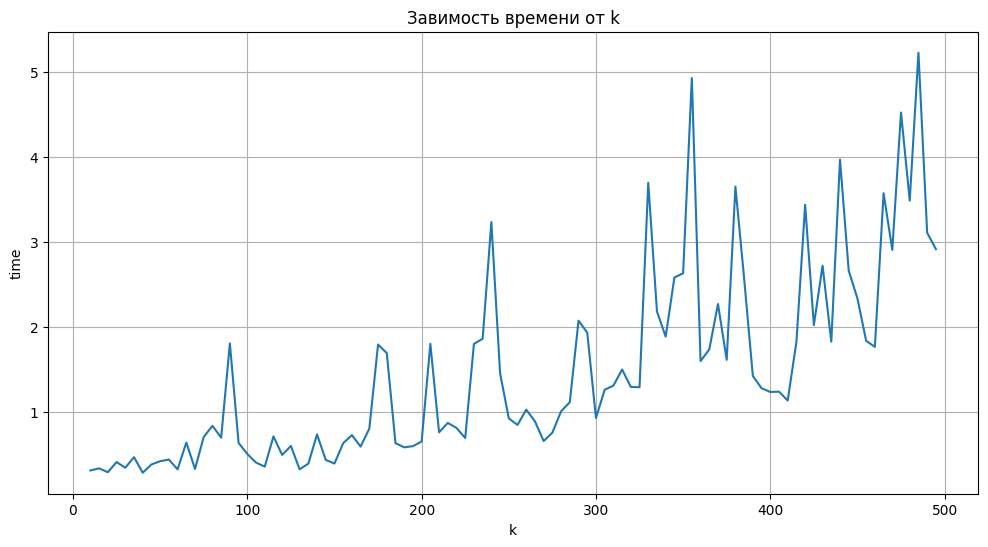

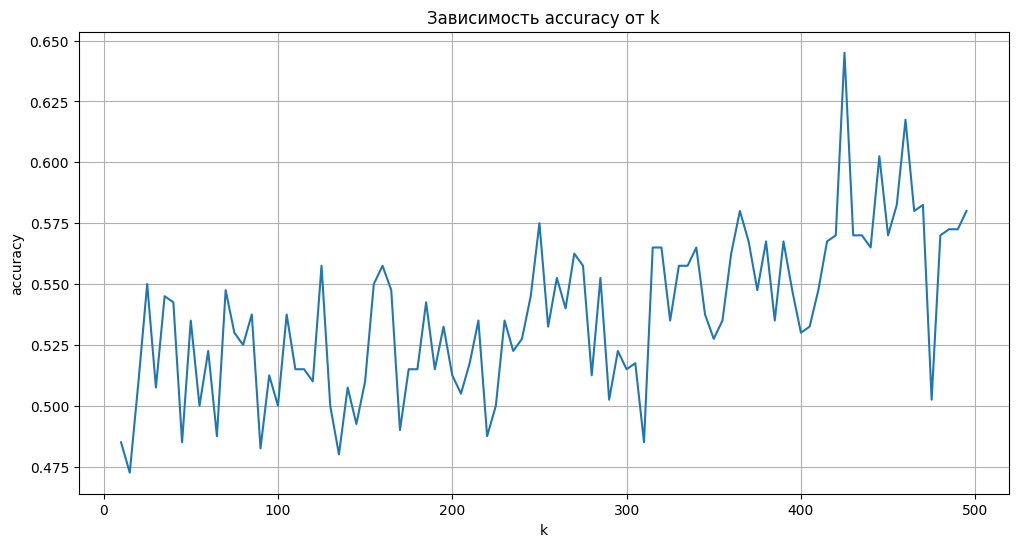

In [35]:
plt.figure(figsize=(12, 6))
plt.title("Завимость времени от k")
plt.xlabel("k")
plt.ylabel("time")
plt.plot(range(10, 500, 5), t)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Зависимость accuracy от k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.grid()
plt.plot(range(10, 500, 5), acc)
plt.show()

Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

<font color='MediumOrchid'>**Ваши выводы тут:**</font>
C увеличением числа компонент качество растет, но время увеличивается

# Калибровка вероятностей

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа (margin), который можно посчитать, используя model.decision_function(X). Именно отступ до разделяющей кривой пытается максимизироавть модель во время обучения. Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте построим следующую кривую:
1) нормализуем отступы так, чтобы они лежали в диапазоне от 0 до 1;

2) разделим все объекты на бины по нормализованному оступу (например на [0, 0.1), [0.1, 0.2)...);

3) для каждого бина построим точку с координатой x - равной среднему значению нормализованного оступа внутри бина, и с координатой y - равной доле объектов класса 1 внутри бина.

Заметим теперь, что если бы нормализованный отступ приблизительно равнялся вероятности отнесения к классу, то бину [x, x + 0.1) должна была бы соответствовать точка с координатой Х принадлежащей [x, x + 0.1) и координатой Y в том же диапазоне. Таким образом, чем лучше скоры модели показывают вероятность отнесения к классу 1, тем больше калибровочная кривая похожа на прямую из точки (0, 0) в (1, 1).

Кроме того построим аналогично кривую для логистической регрессии, взяв вместо нормализованного отступа - вероятность отнесения к первому классу через predict_proba. Так как логистическая регрессия оптимизирует LogLoss и её выходом уже являются вероятности отнесения к классам, будем ожидать что её кривая хорошо ляжет на прямую из (0, 0) в (1, 1).

In [36]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

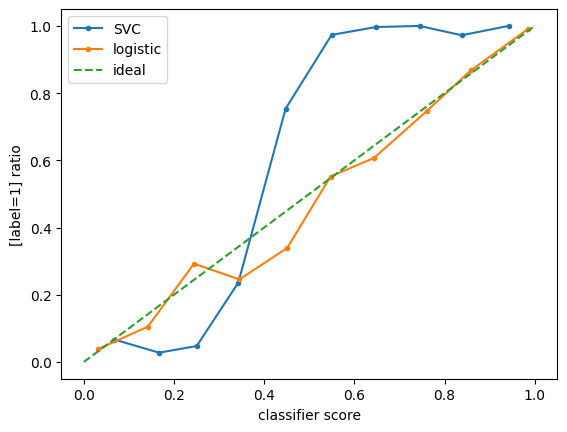

In [37]:
def naive_linear_transform(decision_output):
    return (decision_output - np.min(decision_output)) / (np.max(decision_output) - np.min(decision_output))


# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = SVC()
model.fit(trainX, trainy)
# predict probabilities
probs = naive_linear_transform(model.decision_function(testX))

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10)
# plot perfectly calibrated
# plot model reliability
plt.plot(mpv, fop, marker='.', label='SVC')
plt.xlabel('classifier score')
plt.ylabel('[label=1] ratio')

logistic_model = LogisticRegression()
logistic_model.fit(trainX, trainy)

logistic_probs = logistic_model.predict_proba(testX)[:, 1]

# reliability diagram
log_fop, log_mpv = calibration_curve(testy, logistic_probs, n_bins=10)
# plot perfectly calibrated
# plot model reliability
plt.plot(log_mpv, log_fop, marker='.', label='logistic')
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.legend()
plt.show()

-----------
<font color="white" style="opacity:0.2023"></font>

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Но не всё пропало! Из отступов всё ещё можно получить вероятность отнесения к классу. Для этого существует  такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели.



## <font color='DarkOrange'>**Задание 5 [2 баллa]**</font>

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу (margin) предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [44]:
class CalibratingLogisticRegression:
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here
        x = x.reshape(-1, 1)
        self.model = LogisticRegression()
        self.model.fit(x, y)

    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here
        x = x.reshape(-1, 1)
        return 1/(1+np.exp(-self.model.decision_function(x)))


Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [45]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

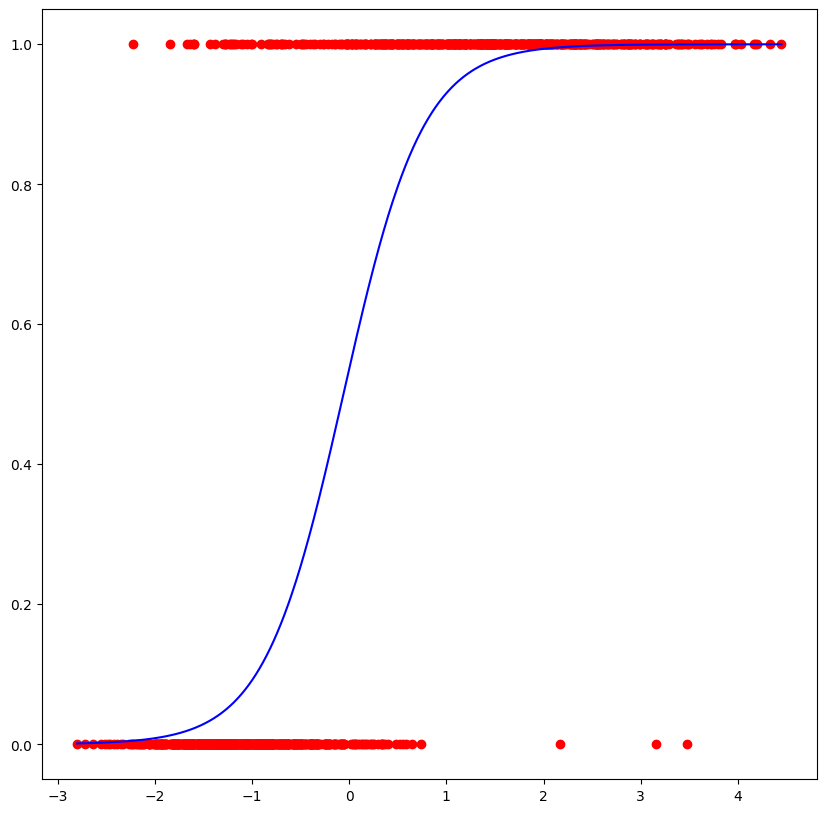

In [46]:
margin = model.decision_function(trainX[N:])


# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(margin, trainy[N:])
prob = calibrating_model.predict_proba(margin)

# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

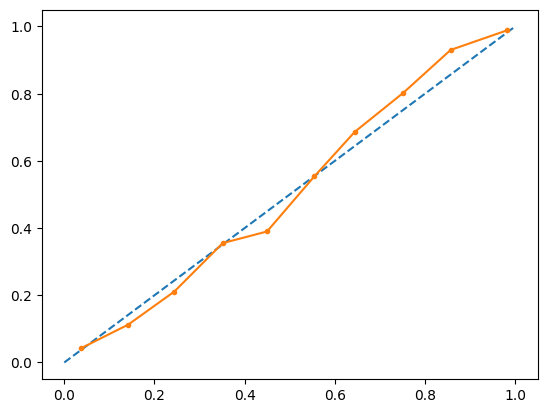

In [47]:
probs = calibrating_model.predict_proba(model.decision_function(testX))
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Обратите внимание, что кривая для откалиброванных отступов должня также строиться для бинов и состоянть из n_bins точек. Если у Вас получилось кривая из трёх точек, Вы что-то сделали неправильно :)

**Сделайте выводы** о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>
После калибровки вероятностей отступы модели стали гораздо точнее отражать реальные вероятности. Такой подход особенно полезен в задачах, где важна интерпретируемость модели, поскольку он позволяет видеть не только предсказание, но и степень уверенности в нем. Это имеет большое значение, например, в медицинских исследованиях, где последствия ложноотрицательной ошибки могут быть значительно серьезнее, чем ложноположительной.